# Wai Yu Amanda, Ng
## Student number: 1008217350

# Part I: t-norm-halfnorm-discrete-uniform model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'loc'}>, <Axes: title={'center': 'loc'}>],
       [<Axes: title={'center': 'df'}>, <Axes: title={'center': 'df'}>],
       [<Axes: title={'center': 'scale'}>,
        <Axes: title={'center': 'scale'}>]], dtype=object)

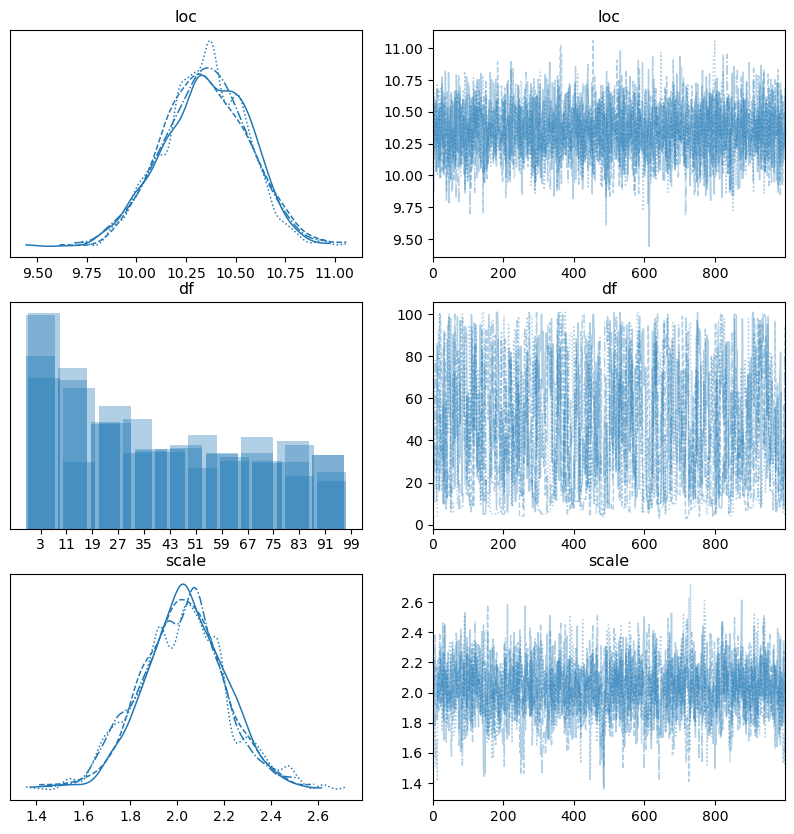

In [2]:
# Import pacakges
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt; import random

# Generate real data
n,loc_true,scale_true,df_true = 100,10,2,15 # True values data will be from... IRL, we don't know these values
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

# Set up PyMC to simulate posterior samples
import pymc as pm
t_norm_halfnorm_discrete_uniform_toy_model = pm.Model()
with t_norm_halfnorm_discrete_uniform_toy_model: 
    loc = pm.Normal("loc", mu=0, sigma=10) 
    scale = pm.HalfNormal("scale", sigma=5) 
    df = pm.DiscreteUniform("df", lower=1, upper=101) 
    x_obs = pm.StudentT("likelihood", nu=df, mu=loc, sigma=scale, observed=x)
    
# Sample posterior data with HMC
with t_norm_halfnorm_discrete_uniform_toy_model:
    idata_HMC = pm.sample()
    
# Traceplot to check convergence
import arviz as az;fig,ax = plt.subplots(3,2, figsize=(10,10))
az.plot_trace(idata_HMC,axes=ax)
# print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()})

## Explore and describe the sample sizes needed to support inference regarding the `df` parameter $(\nu)$

Given the true degree of freedom parameter is 15. From the n=100 example shown above, we observed that Gibbs generated all sorts of degree of freedom samples which are not close to 15, the "inference" is relatively flat (no peaks), so it is not informative.

Now, we will explore how increasing sample size (n) can increase the accuracy of Gibbs samples.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'loc'}>, <Axes: title={'center': 'loc'}>],
       [<Axes: title={'center': 'df'}>, <Axes: title={'center': 'df'}>],
       [<Axes: title={'center': 'scale'}>,
        <Axes: title={'center': 'scale'}>]], dtype=object)

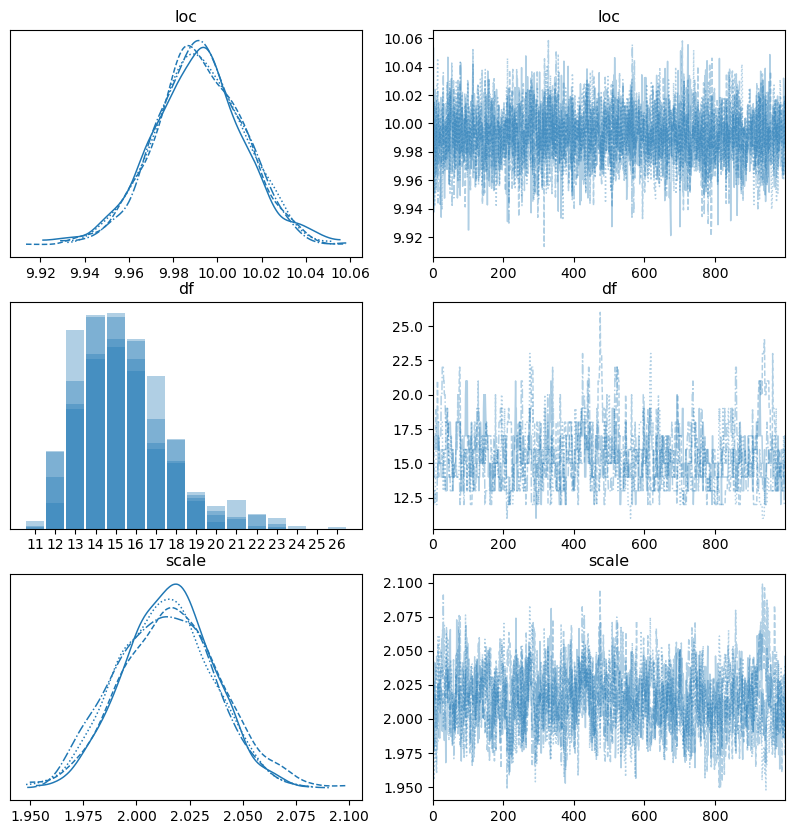

In [3]:
# Generate more  data
n,loc_true,scale_true,df_true = 10000,10,2,15 # True values data will be from... IRL, we don't know these values
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

t_norm_halfnorm_discrete_uniform_toy_model = pm.Model()
with t_norm_halfnorm_discrete_uniform_toy_model: 
    loc = pm.Normal("loc", mu=0, sigma=10) 
    scale = pm.HalfNormal("scale", sigma=5) 
    df = pm.DiscreteUniform("df", lower=1, upper=101) 
    x_obs = pm.StudentT("likelihood", nu=df, mu=loc, sigma=scale, observed=x)
    
with t_norm_halfnorm_discrete_uniform_toy_model:
    idata_HMC = pm.sample()

fig,ax = plt.subplots(3,2, figsize=(10,10))
az.plot_trace(idata_HMC,axes=ax)

As observed above, in the case when n = 10000, the histogram of degree of freedom samples have a distinct peak at around 15, which is closer to the true degree of freedom value and serves as a useful inference. 

# Part II: t-norm-halfnorm-discrete-uniform

## (a) Effective sample size

Total number of samples generated is 4000. See ess_bulk for effective sample size for each parameter.

In [4]:
print("number of MCMC samples:", idata_HMC.posterior['loc'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2)

number of MCMC samples: 4000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc,9.99,0.02,9.95,10.03,0.00,0.00,3530.02,2642.51,1.00
df,15.31,2.10,12.00,19.00,0.11,0.08,355.17,395.87,1.01
scale,2.01,0.02,1.97,2.05,0.00,0.00,517.30,1001.25,1.01


## (b) Chain convergence measures

In [5]:
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()})

HMC Split-Rhats {'loc': 1.0006, 'df': 1.0122, 'scale': 1.0076}


As seen above, Split-Rhats of all parameters are below 1.05, so their markov chains converges.

## (c) Check if there are any divergences

In [6]:
idata_HMC.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(0)

4 chains were created by the algorithm and 0 diverges

## (d) Metropolis-Hastings acceptance rates

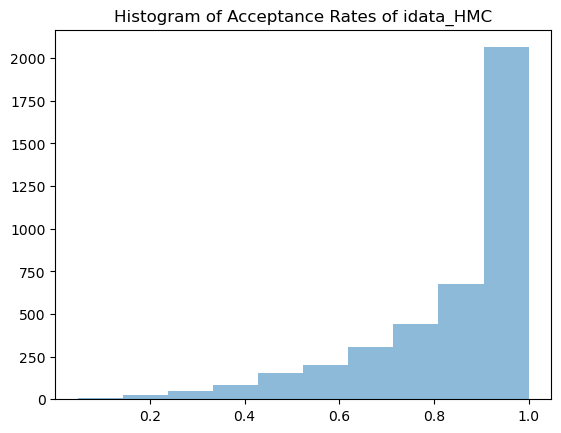

In [7]:
plt.hist(idata_HMC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,);
plt.title('Histogram of Acceptance Rates of idata_HMC');

Refer to the Histogram of Metropolis-Hastings acceptance rates, we see that it is very left-skewed with peak at maximum 1.0, meaning that a lot of samples tend to accept proposal.

## (e) Any other warnings or concers provided by PyMC

1. For loc and scale, of which the priors are continuous, PyMC uses the default NUTS algorithm. For df, of which the piror is discrete, PyMC uses Metropolis algorithm.

2. The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. If we refer to the trace plots, we observe that the scale distributions produced by the chains differ quite a bit, hence the stationary distribution may not be reached based on limited effective sample size.

# Part II : "centered" Eight Schools models

In [8]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

with pm.Model() as Centered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
    
SEED = [20100420, 20134234] # random seeds for each of two run HMC chains
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})
     
     

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## (a) Effective sample size

Total number of samples generated is 10000. See ess_bulk for effective sample size for each parameter. Note that tau has an exceptionally small effective sample size.

In [23]:
print("number of MCMC samples:", fit_C.posterior['mu'].values.flatten().shape[-1])
az.summary(fit_C, round_to=2)

number of MCMC samples: 10000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.23,3.33,-1.67,10.86,0.13,0.10,741.87,559.26,1.00
theta[0],6.34,5.90,-3.69,17.91,0.16,0.11,1179.23,2851.28,1.00
theta[1],4.95,4.97,-4.81,14.13,0.13,0.10,1365.98,4333.22,1.00
theta[2],3.69,5.56,-6.23,14.64,0.12,0.11,1754.17,3517.99,1.00
theta[3],4.63,4.94,-4.40,14.18,0.11,0.10,1807.94,5272.68,1.00
theta[4],3.27,4.76,-5.54,12.86,0.11,0.12,1724.37,3452.88,1.01
theta[5],3.78,5.10,-6.05,13.26,0.11,0.09,1959.60,3571.33,1.01
theta[6],6.50,5.29,-2.85,16.75,0.16,0.11,1087.23,3476.70,1.00
theta[7],4.81,5.51,-5.72,14.96,0.12,0.08,1946.86,4318.71,1.00
tau,4.13,3.24,0.69,10.05,0.18,0.13,59.84,20.08,1.04


## (b) Chain convergence measures

In [24]:
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fit_C).items()})

HMC Split-Rhats {'mu': 1.0022, 'theta': array([1.0021, 1.0017, 1.0047, 1.0028, 1.0076, 1.0056, 1.0028, 1.0041]), 'tau': 1.0355}


As seen above, Split-Rhats of all parameters are below 1.05, so their markov chains converges.

## (c) Divergence

In [25]:
fit_C.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(433)

Under this model, we found 433 divergences.

## (d) Metropolis-Hastings acceptance rates

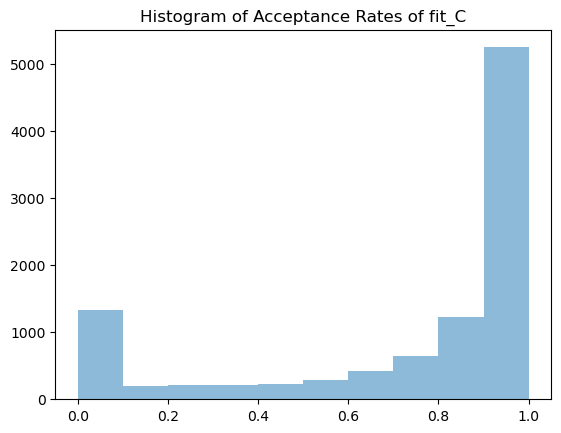

In [15]:
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,);
plt.title('Histogram of Acceptance Rates of fit_C');

Refer to the Histogram of Metropolis-Hastings acceptance rates, we see that it is very left-skewed with peak at maximum 1.0, meaning that a lot of samples tend to accept proposal.

## (e) Any other warnings or concers provided by PyMC

PyMC recommended running at least 4 chains for robust computation of convergence diagnostics. In this algorithm, we only produced 2 chains. Hence, we should consider setting another sets of initial values and run the algorithm again to get more robust conclusions.
    

# Part II: "uncentered" Eight Schools models

In [16]:
with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
    

with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta_t]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## (a) Effective sample size: 

Total number of samples generated is 10000. See ess_bulk for effective sample size for each parameter. Observe that most parameters have higher effective sample size under this model compared to the previous "centered" model. In particular, tau has a much higher effective sample size under this "uncentered" model.

In [26]:
print("number of MCMC samples:", fit_NC.posterior['mu'].values.flatten().shape[-1])
az.summary(fit_NC, round_to=2)

number of MCMC samples: 10000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.41,3.27,-1.90,10.42,0.03,0.02,11903.60,6680.07,1.0
theta_t[0],0.32,0.96,-1.47,2.14,0.01,0.01,11852.45,7047.14,1.0
theta_t[1],0.10,0.93,-1.69,1.83,0.01,0.01,15651.36,7495.38,1.0
theta_t[2],-0.08,0.97,-1.83,1.81,0.01,0.01,16057.59,7168.45,1.0
theta_t[3],0.06,0.95,-1.70,1.84,0.01,0.01,14902.11,7324.68,1.0
theta_t[4],-0.16,0.94,-1.93,1.63,0.01,0.01,16499.83,7639.02,1.0
theta_t[5],-0.07,0.96,-1.85,1.73,0.01,0.01,13772.90,7344.10,1.0
theta_t[6],0.36,0.95,-1.43,2.14,0.01,0.01,13822.12,7340.51,1.0
theta_t[7],0.07,0.98,-1.83,1.87,0.01,0.01,14590.20,7186.53,1.0
tau,3.63,3.28,0.00,9.46,0.05,0.04,5956.38,4441.06,1.0


## (b) Chain convergence measures

In [18]:
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fit_NC).items()})

HMC Split-Rhats {'mu': 0.9999, 'theta_t': array([1.0003, 1.0001, 1.0002, 1.    , 1.0002, 1.0003, 1.0002, 1.0002]), 'tau': 1.0004, 'theta': array([0.9999, 1.    , 1.0001, 1.0003, 1.    , 1.    , 1.    , 1.0001])}


As seen above, Split-Rhats of all parameters are below 1.05, so their markov chains converges.

## (c) Divergence: 

In [19]:
fit_NC.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(12)

Under this model, we only found 12 divergences, which is a significant reduction compared to the previous "centered" model.

## (d) Metropolis-Hastings acceptance rates

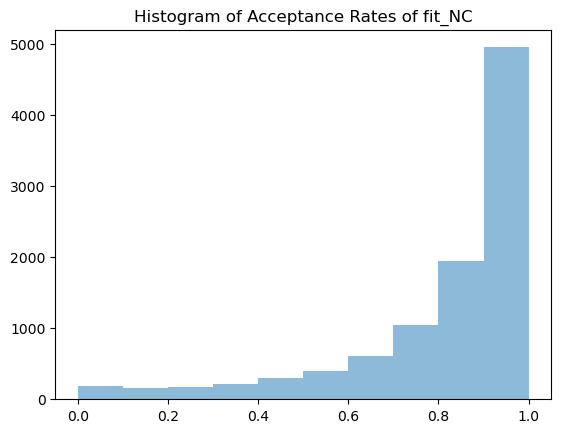

In [20]:
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,);
plt.title('Histogram of Acceptance Rates of fit_NC');

Refer to the Histogram of Metropolis-Hastings acceptance rates, we see that it is very left-skewed with peak at maximum 1.0, meaning that a lot of samples tend to accept proposal. Note that the "uncentered" model gives less samples that have 0 (absolutely-impossible) acceptance probability than the "centered" model.

## (e) Any other warnings or concers provided by PyMC


PyMC recommended running at least 4 chains for robust computation of convergence diagnostics. In this algorithm, we only produced 2 chains. Hence, we should consider setting another sets of initial values and run the algorithm again to get more robust conclusions.

# Part II: 

## From the perspective of curvature of the energy function (that is, how rapidly the log joint posterior distribution density changes for different values of its random variable (parameters) and the effectiveness of the HMC algorithm, explain why the "uncentered" paramterization of the model performs better than the "centered" parameterization

In the "centered" model, changes in theta is conducted directly by changes in tau. Since we specified:
    
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J)

In the case when tau was sampled with a small value, density distirbution of theta, of which variance depends on tau, becomes "narrow". Hence, for small tau, the density evaluation can change rapidly as theta changes. Consequently, the log joint posterior distribution density could change rapidly for changes in theta, meaning that the energy has high curvature, we have therefore "flown off" the mass of our target distribution. The "flown off" proposals are not likely to have high acceptance probability and hence will be rejected. Then, the HMC algorithm is not effective in producing useful proposals in this case. 

There are many divergences because the specification in "centered" model induces high curature in the energy, but the alternative "uncentered" parameterization alleviates this problem.
    

In the "uncentered" model, changes in theta take place on a fixed scale that is independent of tau, which is shown below:
    
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    
Here, we have theta_tilde independent of tau. When evaluating theta, we use non-random model which takes in mu and tau while tau is on a fixed scale theta_tilde.

        theta = pm.Deterministic("theta", mu + tau * theta_tilde)

**Note that we are only interested in theta and mu.**
Although, changes in tau may still result in rapid changes in the log joint posterior distribution density and the energy still has high curvature with respect to tau. However, in the formula for theta: mu + tau * theta_tilde, no matter how big or how small tau is, it does not control "narrowness" of the theta distribution. So, the energy no longer has high curvature with respect to theta since changes in theta is independent of tau. Hence, the curvature on energy is reduced and energy function is closer to the target distirbution.

## Review [this](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#model-checking) and [that](https://discourse.pymc.io/t/about-nuts-sampling-and-energy-plot/831) discussing the ***diagnostic plot*** which compares the ***observed energy proposal distribution*** versus the ***empirical energy distribution*** of the generated HMC samples
- Use the code on the next slide to provide and interpret the ***diagnostic plot*** assessing ***energy proposals*** versus the empirical ***energy*** distribution to compare and contrast the "centered" and "uncentered" Eight Schools models in relation to you previous comparision of these two model parameterization in terms of ***energy function curvature*** and the effectiveness of the ***HMC*** algorithm... does this diagnostic support your previous conclusions in these regards?

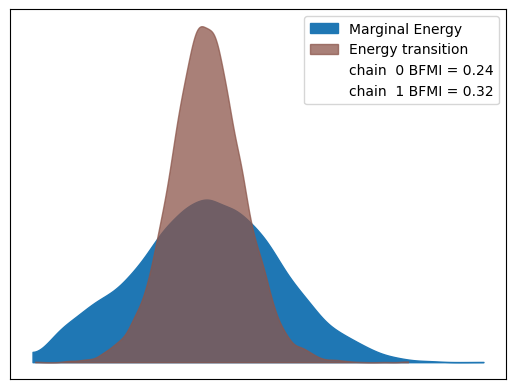

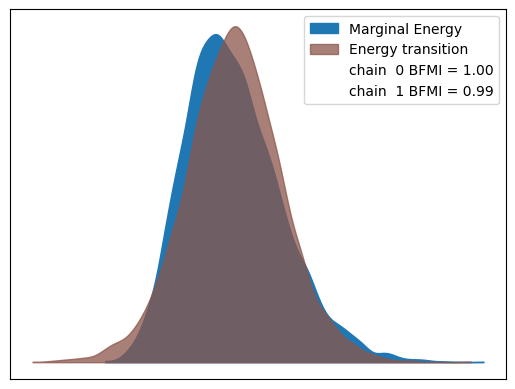

In [22]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

In "centered" Eight Schools models, the distributions are very different from one another. Here, we have the energy transition (proposal) distribution much more narrow than marginal (empirical) energy distribution, which means we dont have enough energy to explore the whole parameter space and our posterior estimation is likely biased. 

In "uncentered" Eight Schools models, the distributions are very similar to one another, so we have sufficient energy to explore the whole parameter space and our posterior estimation is likely to be accurate.

This diagnostic supports my previous conclusions in these regards.